In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import re
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [3]:
df = pd.read_csv('case_study_data_ver1.csv', sep = ';')

In [4]:
df['QTY'] = df['QTY'].astype(str)
outtakes = df[df.QTY.str.contains('[a-zA-Z]|\.\d\d$|\.\d\d\d\d$')]
df = df.drop(outtakes.index)
df['QTY'] = df['QTY'].apply(lambda x: re.sub('\.','',re.sub('\..$','',x))).astype(float)
df = df.drop([key for key in list(df.keys()) if df[key].sum()==0], axis=1)

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

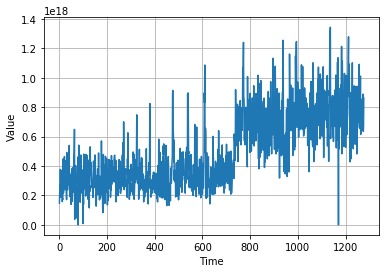

In [6]:
ts = df.groupby(['DATE_ID'])['QTY'].sum().reset_index(name='sum(QTY)')
time = ts.DATE_ID.values
series = ts['sum(QTY)'].values
plot_series(time,series)

In [7]:
split_time = 365*2
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
23/23 [==============================] - 11s 485ms/step - loss: 355506912687144256.0000 - mae: 354042606704918528.0000
Epoch 2/100
23/23 [==============================] - 1s 47ms/step - loss: 354400764432768640.0000 - mae: 354042537985441792.0000
Epoch 3/100
23/23 [==============================] - 1s 45ms/step - loss: 354540702927805632.0000 - mae: 354042537985441792.0000
Epoch 4/100
23/23 [==============================] - 1s 45ms/step - loss: 354018454211713024.0000 - mae: 354042606704918528.0000
Epoch 5/100
23/23 [==============================] - 1s 46ms/step - loss: 353777864289567040.0000 - mae: 354042572345180160.0000
Epoch 6/100
23/23 [==============================] - 1s 44ms/step - loss: 354007403951526912.0000 - mae: 354042572345180160.0000
Epoch 7/100
23/23 [==============================] - 1s 46ms/step - loss: 354093216869975168.0000 - mae: 354042572345180160.0000
Epoch 8/100
23/23 [==============================] - 1s 44ms/step - loss: 354707114582877056.00

23/23 [==============================] - 1s 44ms/step - loss: 354046933999404992.0000 - mae: 354042572345180160.0000
Epoch 65/100
23/23 [==============================] - 1s 43ms/step - loss: 353831592366274944.0000 - mae: 354042572345180160.0000
Epoch 66/100
23/23 [==============================] - 1s 43ms/step - loss: 353228973512075648.0000 - mae: 354042572345180160.0000
Epoch 67/100
23/23 [==============================] - 1s 44ms/step - loss: 354200808934777344.0000 - mae: 354042537985441792.0000
Epoch 68/100
23/23 [==============================] - 1s 44ms/step - loss: 353072318471988736.0000 - mae: 354042606704918528.0000
Epoch 69/100
23/23 [==============================] - 1s 44ms/step - loss: 354496546325375616.0000 - mae: 354042537985441792.0000
Epoch 70/100
23/23 [==============================] - 1s 44ms/step - loss: 354121733554934272.0000 - mae: 354042572345180160.0000
Epoch 71/100
23/23 [==============================] - 1s 43ms/step - loss: 355311005027239424.0000 - ma

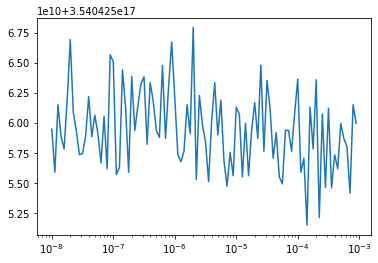

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 30])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

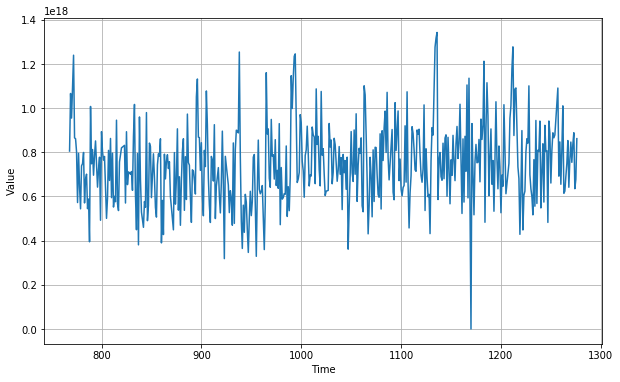

In [13]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [15]:
history.history.keys()

dict_keys(['loss', 'mae'])

Text(0.5, 0, 'epoch')

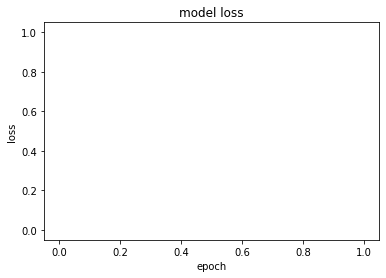

In [16]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [19]:
max(history.history['loss'])

nan